In [344]:
import numpy as np
import pandas as pd
import os
import pymongo

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
train_on_gpu = torch.cuda.is_available()
from sklearn.decomposition import PCA
from sklearn import preprocessing
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available.')

CUDA is available.


In [345]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
sns.set_style('whitegrid')
from os import listdir
from os.path import isfile, join
from pandas_datareader import data
import yfinance as yf
import math
import pmdarima as pm

In [346]:
AAPL_df = pd.read_csv('collected_df.csv')
AAPL_df = pd.read_csv('collected_df.csv', index_col = [0])
AAPL_cols = AAPL_df.columns.tolist()
AAPL_cols.remove('Close')
AAPL_cols = ['Close'] + AAPL_cols
AAPL_df = AAPL_df[AAPL_cols]
# AAPL_df = AAPL_df[['Date', 'Close']]
AAPL_df

,Close,Date,Volume,Adj Close,^DJI_Close,^IXIC_Close,^GSPC_Close,^RLG_Close,^NYA_Close,^VIX_Close,...,BACTSAMFRBDAL,IR,IQ,PPIACO,CPIAUCSL,CPILFESL,MICH,CSCICP03USM665S,Grow,News_Score
0,27.332500,2015-01-02,212818400,24.565697,17832.990234,4726.810059,2058.199951,960.280029,10830.919922,17.790001,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,False,0.500000
1,26.562500,2015-01-05,257142000,23.873644,17501.650391,4652.569824,2020.579956,943.780029,10607.679688,19.920000,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,False,0.500375
2,26.565001,2015-01-06,263188400,23.875887,17371.640625,4592.740234,2002.609985,935.020020,10514.870117,21.120001,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.719541
3,26.937500,2015-01-07,160423600,24.210682,17584.519531,4650.470215,2025.900024,946.880005,10627.129883,19.309999,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.074792
4,27.972500,2015-01-08,237458000,25.140909,17907.869141,4736.189941,2062.139893,964.159973,10800.540039,17.010000,...,-4.5,126.0,126.1,192.000,234.747,239.811,2.5,101.143074,True,0.996247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,131.860001,2022-12-23,63814900,131.658981,33203.929688,10497.860352,3844.820068,2165.620117,15188.450195,20.870001,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.696560
2003,130.029999,2022-12-27,69007800,129.831772,33241.558594,10353.230469,3829.250000,2144.899902,15218.259766,21.650000,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.312938
2004,126.040001,2022-12-28,85438400,125.847855,32875.710938,10213.290039,3783.219971,2117.199951,15037.320312,22.139999,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,False,0.175638
2005,129.610001,2022-12-29,75703700,129.412415,33220.800781,10478.089844,3849.280029,2163.790039,15241.209961,21.440001,...,-20.0,141.8,150.7,258.012,298.990,301.460,4.4,96.919411,True,0.930547


In [415]:
from sklearn.preprocessing import MinMaxScaler


def data_normalisation(df):
    scaler=MinMaxScaler(feature_range=(0,1))
    
    for column_name in list(df.columns.values):
        if column_name == 'Date':
            continue
        the_list = df[column_name].tolist()
        the_list = np.array(the_list)
        the_list = scaler.fit_transform(the_list.reshape(-1,1))
        df.drop(column_name, axis = 1, inplace = True)
        df[column_name] = the_list
    return df,scaler
        
def split_train_test_data(df, lookback, pred_length=1):
    df_list = df.loc[:, df.columns != 'Date'].values.tolist()
    res_list = df['Close'].tolist()
    res_list = np.array(res_list)
    print(len(res_list))
    data = []
    res_data = []

    for index in range(len(df_list) - lookback - pred_length + 1): 
        the_list = df_list[index: index + lookback]
        the_list= np.array(the_list)
#         the_list= np.transpose(the_list)
        if index==0:
            print(the_list)
        data.append(the_list)
        res_data.append(res_list[index + lookback:index + lookback + pred_length])

    data = np.array(data)
    res_data = np.array(res_data)
    
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)*2
    
    x_train = data[:train_set_size]
    y_train = res_data[:train_set_size]
    y_train = np.squeeze(y_train)
    
    x_val = data[train_set_size:train_set_size+test_set_size]
    y_val = res_data[train_set_size:train_set_size+test_set_size]
    y_val = np.squeeze(y_val)
    
    x_test = data[train_set_size+test_set_size:]
    y_test = res_data[train_set_size+test_set_size:]
    y_test = np.squeeze(y_test)
    
    return x_train, y_train,x_val,y_val, x_test, y_test

In [416]:
class MyDataLoader(Dataset):
    def __init__(self, x_list, y_list):

        self.x_list = x_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.x_list)
    

    def __getitem__(self, idx):
        x_data = self.x_list[idx]
        y_data = self.y_list[idx]
        sample = {'Data': x_data, 'Labels': y_data}

        return sample

In [417]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from torch import nn, Tensor

# class TransAm(nn.Module):
#     def __init__(self, feature_size: int = 510, num_layers: int = 2, dropout: float = 0.1):
#         super(TransAm, self).__init__()
#         self.model_type = 'Transformer'
#         self.src_mask = None
#         self.pos_encoder = PositionalEncoding(feature_size)
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
#         self.decoder = nn.Linear(feature_size, 1)
#         self.linear1 = nn.Linear(SEQ_LEN, OUTPUT_DIMENSION)
#         self.init_weights()
#         self.src_key_padding_mask = None

#     def init_weights(self):
#         initrange = 0.1
#         nn.init.zeros_(self.decoder.bias)
#         nn.init.uniform_(self.decoder.weight, -initrange, initrange)

#     def forward(self, src: torch.Tensor, seq_len: int = 510) -> torch.Tensor:
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src)
#         output = self.decoder(output)
#         output = torch.squeeze(output)
#         output = self.linear1(output)
#         return output

class TransformerModel(nn.Module):

    def __init__(self, d_input, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, output_size: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.embedding1 = nn.Linear(d_input, d_input//2 )
        self.embedding2 = nn.Linear(d_input//2, 1)
        
#         self.pos_encoder = PositionalEncoding1D(d_model)
        self.pos_encoder = PositionalEncodingPermute1D(d_model)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)

        self.projection = nn.Linear(d_model, d_model)
        self.d_model = d_model
        self.decoder_1 = nn.Linear(d_model, d_model//2)
        self.decoder_2 = nn.Linear(d_model//2, output_size)
        self.relu = nn.ReLU()
        self.out_activation = nn.Tanhshrink()
#         self.activation = nn.Tanh()
#         self.activation = nn.LogSoftmax(dim=2)
#         self.activation = nn.Softmax(dim=2)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder_1.bias.data.zero_()
        self.decoder_1.weight.data.uniform_(-initrange, initrange)
        self.decoder_2.bias.data.zero_()
        self.decoder_2.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
#     def forward(self, src: Tensor, src_mask: Tensor, target: Tensor, trg_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
#         src = self.encoder(src) * math.sqrt(self.d_model)

        device = src.device
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        src_mask = mask
        x = torch.clone(src)
#         src = self.pos_encoder(src)
#         print(src.size())
        src = self.embedding1(src)
        src = self.embedding2(src)
        src = torch.squeeze(src, -1)
#         print(src.size())
            
        src = self.projection(src)
#         print(src.size())
        output = self.transformer_encoder(src, src_mask)
#         print(output.size())
#         trg = self.encoder(target) * math.sqrt(self.d_model)
#         trg = self.pos_encoder(target)
#         trg = self.projection(trg)
        
#         output = self.transformer_decoder(trg, output, tgt_mask = trg_mask)
        output = self.decoder_1(output)
        output = self.relu(output)
        output = self.decoder_2(output)
        x = torch.unsqueeze(x[:,-1,0], 1)
#         print(output.size())
        output = self.out_activation(output) + x
#         print(output.size())
        return output


    def _generate_square_subsequent_mask(self, sz):
            mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask

    def _gen_bias_mask(max_length): # added
        """
        Generates bias values (-Inf) to mask future timesteps during attention
        """
    #     np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
        np_mask = np.triu(np.full([max_length, max_length], 0), 1)
        torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)

        # Reshape to 4D Tensor to handle multiple heads
        return torch_mask.unsqueeze(0).unsqueeze(1)
    
def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc

class PositionalEncodingPermute1D(nn.Module):
    def __init__(self, channels):
        """
        Accepts (batchsize, ch, x) instead of (batchsize, x, ch)
        """
        super(PositionalEncodingPermute1D, self).__init__()
        self.penc = PositionalEncoding1D(channels)

    def forward(self, tensor):
        tensor = tensor.permute(0, 2, 1)
        enc = self.penc(tensor)
        return enc.permute(0, 2, 1)

    @property
    def org_channels(self):
        return self.penc.org_channels
    
    
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x: Tensor) -> Tensor:
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
#         """
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

In [418]:
def train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma):
    n_epochs = 150
    last_epochs=0
    var_value = 0.0
    train_loss_res=[]
    valid_loss_res=[]
    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for i_batch, sample_batched in enumerate(train_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data=data_batch.float()
            target = labels_batch.float()
#             print(data.size())
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()

            optimizer.zero_grad()
            output = model(data)
#             print(output.size(),target.size(), var.size())
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            # criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)


        model.eval()
        for i_batch, sample_batched in enumerate(val_loader):
            data_batch,labels_batch = sample_batched['Data'], sample_batched['Labels']
            data = data_batch.float()
            target = labels_batch.float()
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            var = torch.tensor([var_value]*data.size(0))
            var = torch.unsqueeze(var, 1)
            if train_on_gpu:
                var = var.cuda()
            output = model(data)

            # loss = criterion(output, target)
            loss = gamma * NLL_Loss(output, target, var) + alpha * MAE_Loss(output, target)
            valid_loss += loss.item()*data.size(0)

    #     print(len(train_loader.sampler))
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        train_loss_res.append(train_loss)
        valid_loss_res.append(valid_loss)

        if valid_loss <= valid_loss_min:
            last_epochs=epoch
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss
        if epoch-last_epochs>50:
            break
    return model

In [419]:
def combine_values(the_list,last=True):
    res=[]
    for i in range(len(the_list)):
        if last:
            if i==len(the_list)-1:
                for ii in range(len(the_list[i])):
                    res.append(the_list[i][ii])
            else:
                res.append(the_list[i][0])
        else:
            res.append(the_list[i][0])
    res=np.array(res)
    return res

In [420]:
def forecast_accuracy(forecast, actual):
    print(forecast.shape)
    print(forecast)
    print(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

def denormalise(the_df,thevalue):
    themax=the_df['Close'].max()
    themin=the_df['Close'].min()
    therange = themax - themin
    thevalue = thevalue*therange+themin
#     print(thevalue)
    return thevalue

In [421]:
def evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, the_df, lookback, pred_length, is_stock =  True):
    actual_values = np.concatenate((y_train.detach().cpu().numpy(),  y_val.detach().cpu().numpy()), axis=0)[:,0]
    actual_values = np.concatenate((actual_values,y_test.detach().cpu().numpy()[:,0]), axis=0)
    actual_values = denormalise(the_df,actual_values)
    print(actual_values.shape)
    actual = actual_values
#     combine_values(actual_values)
    print(actual.shape)
    devide = 16
    train_len = len(x_train)//devide
    

    # actual =  np.concatenate(actual)
    if train_on_gpu:
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_train[int(i*train_len):].cuda()).detach().cpu().numpy()[:,0]
            else:
                temp_predict = model(x_train[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()[:,0]
            if i ==0:
                predict = temp_predict[:]
            else:     
                predict = np.concatenate((predict, temp_predict), axis=None)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_val[int(i*train_len):].cuda()).detach().cpu().numpy()[:,0]
            else:
                temp_predict = model(x_val[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()[:,0]
            if i ==0:
                val_predict = temp_predict[:]
            else:     
                val_predict = np.concatenate((val_predict, temp_predict), axis=None)
        for i in range(devide):
            if i == devide -1:
                temp_predict = model(x_test[int(i*train_len):].cuda()).detach().cpu().numpy()[:,0]
            else:
                temp_predict = model(x_test[int(i*train_len):int((i+1)*train_len)].cuda()).detach().cpu().numpy()[:,0]
            if i ==0:
                test_predict = temp_predict[:]
            else:     
                test_predict = np.concatenate((test_predict, temp_predict), axis=None)
                
#         val_predict = model(x_val.cuda()).detach().cpu().numpy()
#         test_predict = model(x_test.cuda()).detach().cpu().numpy()
    else:
        predict = model(x_train).detach().numpy()
        val_predict = model(x_val).detach().numpy()
        test_predict = model(x_test).detach().numpy()
    predict = denormalise(the_df,predict)
    val_predict = denormalise(the_df,val_predict)
    test_predict = denormalise(the_df,test_predict)
    print('predict',predict.shape)   
    train_num = len(predict)
    train_sum = 0 
    for i in range(train_num):
        train_sum += np.abs(actual_values[i]-predict[i])
    print('Train Loss:',train_sum.sum()/train_num)

    val_num = len(val_predict)
    val_sum = 0 
    for i in range(val_num):
        val_sum += np.abs(actual_values[train_num+i]-val_predict[i])
    print('Val Loss:',val_sum.sum()/val_num)

    test_num = len(test_predict)
    test_sum = 0 
    for i in range(test_num):
        test_sum += np.abs(actual_values[val_num+train_num+i]-test_predict[i])
    print('Test Loss:',test_sum.sum()/test_num)
#     predict=combine_values(predict,True)
    print('predict',predict.shape)
#     val_predict=combine_values(val_predict,True)
    print('val_predict',val_predict.shape)
    
#     val_predict = np.append(val_predict,test_predict[0])
#     print(len(val_predict))
    os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
    
    print('test_predict',test_predict.shape)
    the_df['Date'] = pd.to_datetime(the_df['Date'], format='%Y-%m-%d')

    data_date = the_df['Date'].tolist()
    data_date = np.array(data_date[lookback:-pred_length+1])
        # data_len = len(data_date)
    fig = figure(figsize=(25, 5), dpi=300)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, actual, label="Actual Prices", color='b')
    plt.plot(data_date[:len(predict)], predict, label="Predicted Training Prices", color='r')
    plt.plot(data_date[len(predict):len(predict)+len(val_predict)], val_predict, label="Predicted Validation Prices", color='g')
    plt.plot(data_date[len(predict)+len(val_predict):], test_predict, label="Predicted Testing Prices", color='k')
    plt.title("Predicted Close Prices and Actual Close Prices")

    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.savefig('Data_Pred.png')
    plt.show()

    
    torch.cuda.empty_cache()
    print(len(actual_values[:train_num]),len(actual_values[train_num:val_num+train_num]),len(actual_values[val_num+train_num:]))
    print(len(predict),len(val_predict),len(test_predict))
    print(len(x_val))

    print(forecast_accuracy(actual_values[:train_num],predict))
    print(forecast_accuracy(actual_values[train_num:val_num+train_num],val_predict))
    print(forecast_accuracy(actual_values[val_num+train_num:],test_predict))


In [422]:
torch.cuda.empty_cache()

(1978,)
(1978,)
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([76, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([26, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([74, 38, 15])
torch.Size([26, 38, 15])
torch.Size([0, 38, 15])
torch.Size([0, 38, 1

C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


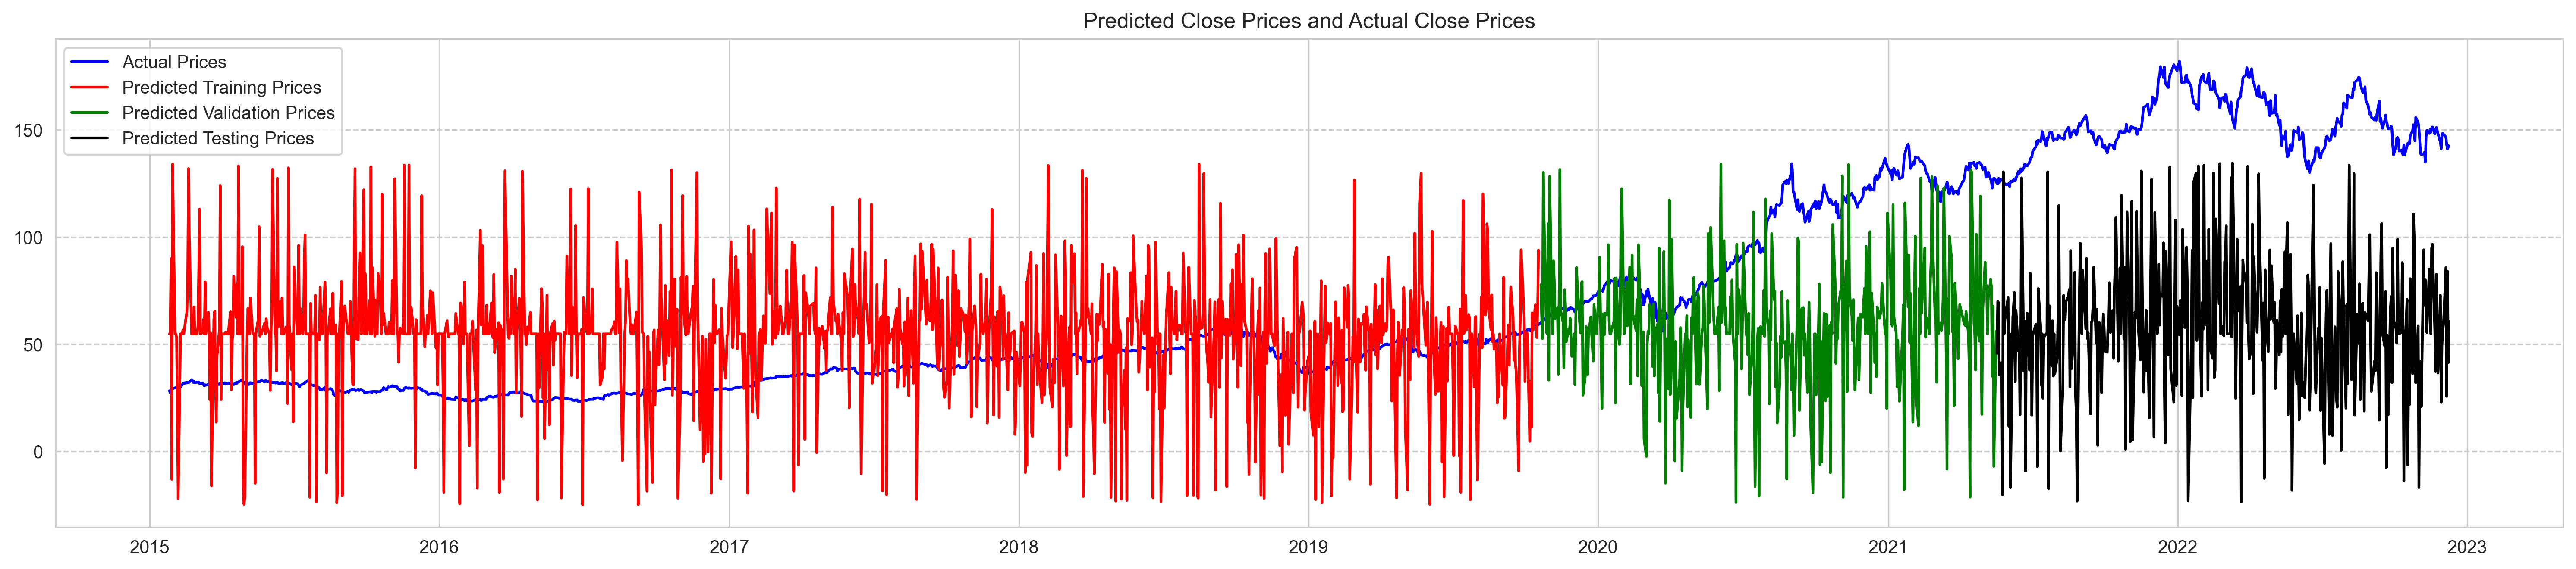

1186 396 396
1186 396 396
396
(1186,)
[28.275  27.285  28.8275 ... 58.5925 58.82   59.1025]
[54.80306  54.862965 89.84452  ... 53.06968  68.65151  93.8436  ]
{'mape': 0.92045605, 'me': -16.447388, 'mae': 28.305468, 'mpe': -0.59014726, 'rmse': 34.84133259551434, 'corr': -0.05753405336057482, 'minmax': 0.46979308128356934}
(396,)
[ 60.1275    59.990005  60.795     60.895004  61.645     62.262505
  60.8225    60.815     62.19      63.955     64.375     64.2825
  64.31      64.8575    65.035     65.55      65.49      66.11751
  65.66      66.44      66.77501   66.57251   65.7975    65.5025
  65.445     66.5925    66.07251   66.96001   66.8125    66.04
  64.8625    65.435     66.395004  67.677505  66.73      67.12001
  67.692505  67.865     68.7875    69.965     70.1025    69.935
  70.005     69.86      71.        71.0675    72.4775    72.45
  72.88      73.412506  75.08751   74.3575    74.95      74.5975
  75.7975    77.4075    77.582504  79.240005  78.17      77.835
  78.81      79.6825  

In [423]:
evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)

2007
[[0.0297789  0.28946222 0.02304532 0.10278454 0.0390116  0.07721029
  0.03296827 0.23944136 0.11760707 0.09757073 0.85565484 0.94078641
  0.13510538 0.2264055  0.55984628 0.         0.         0.
  0.         0.08963356 0.42032773 0.04252972 0.89438758 0.93579767
  0.         0.91113392 0.69756554 0.74834983 0.62611012 0.28115016
  0.16460905 0.10813433 0.         0.         0.12121212 0.91089716
  0.         0.50058757]
 [0.02494904 0.3616941  0.0187146  0.08711055 0.03271504 0.06453287
  0.02556219 0.2134117  0.14656695 0.10932604 0.80658491 0.88362576
  0.15299289 0.25159944 0.54342034 0.14418058 0.53602637 0.04790614
  0.1029399  0.08963356 0.42032773 0.04252972 0.89438758 0.93579767
  0.         0.91113392 0.69756554 0.74834983 0.62611012 0.28115016
  0.16460905 0.10813433 0.         0.         0.12121212 0.91089716
  0.         0.50096331]
 [0.02496473 0.37154761 0.01872864 0.08096045 0.02764069 0.05847723
  0.02163024 0.20259017 0.1628824  0.11402834 0.80403938 0.87847077
 

Epoch: 0 	Training Loss: 0.787515 	Validation Loss: 2.969957
Validation loss decreased (inf --> 2.969957).  Saving model ...
Epoch: 1 	Training Loss: 0.785457 	Validation Loss: 2.957555
Validation loss decreased (2.969957 --> 2.957555).  Saving model ...
Epoch: 2 	Training Loss: 0.787034 	Validation Loss: 2.954556
Validation loss decreased (2.957555 --> 2.954556).  Saving model ...
Epoch: 3 	Training Loss: 0.783294 	Validation Loss: 2.942614
Validation loss decreased (2.954556 --> 2.942614).  Saving model ...
Epoch: 4 	Training Loss: 0.785250 	Validation Loss: 2.940477
Validation loss decreased (2.942614 --> 2.940477).  Saving model ...
Epoch: 5 	Training Loss: 0.783559 	Validation Loss: 2.938502
Validation loss decreased (2.940477 --> 2.938502).  Saving model ...
Epoch: 6 	Training Loss: 0.780879 	Validation Loss: 2.920006
Validation loss decreased (2.938502 --> 2.920006).  Saving model ...
Epoch: 7 	Training Loss: 0.785367 	Validation Loss: 2.931765
Epoch: 8 	Training Loss: 0.778537 

C:\Users\13862\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


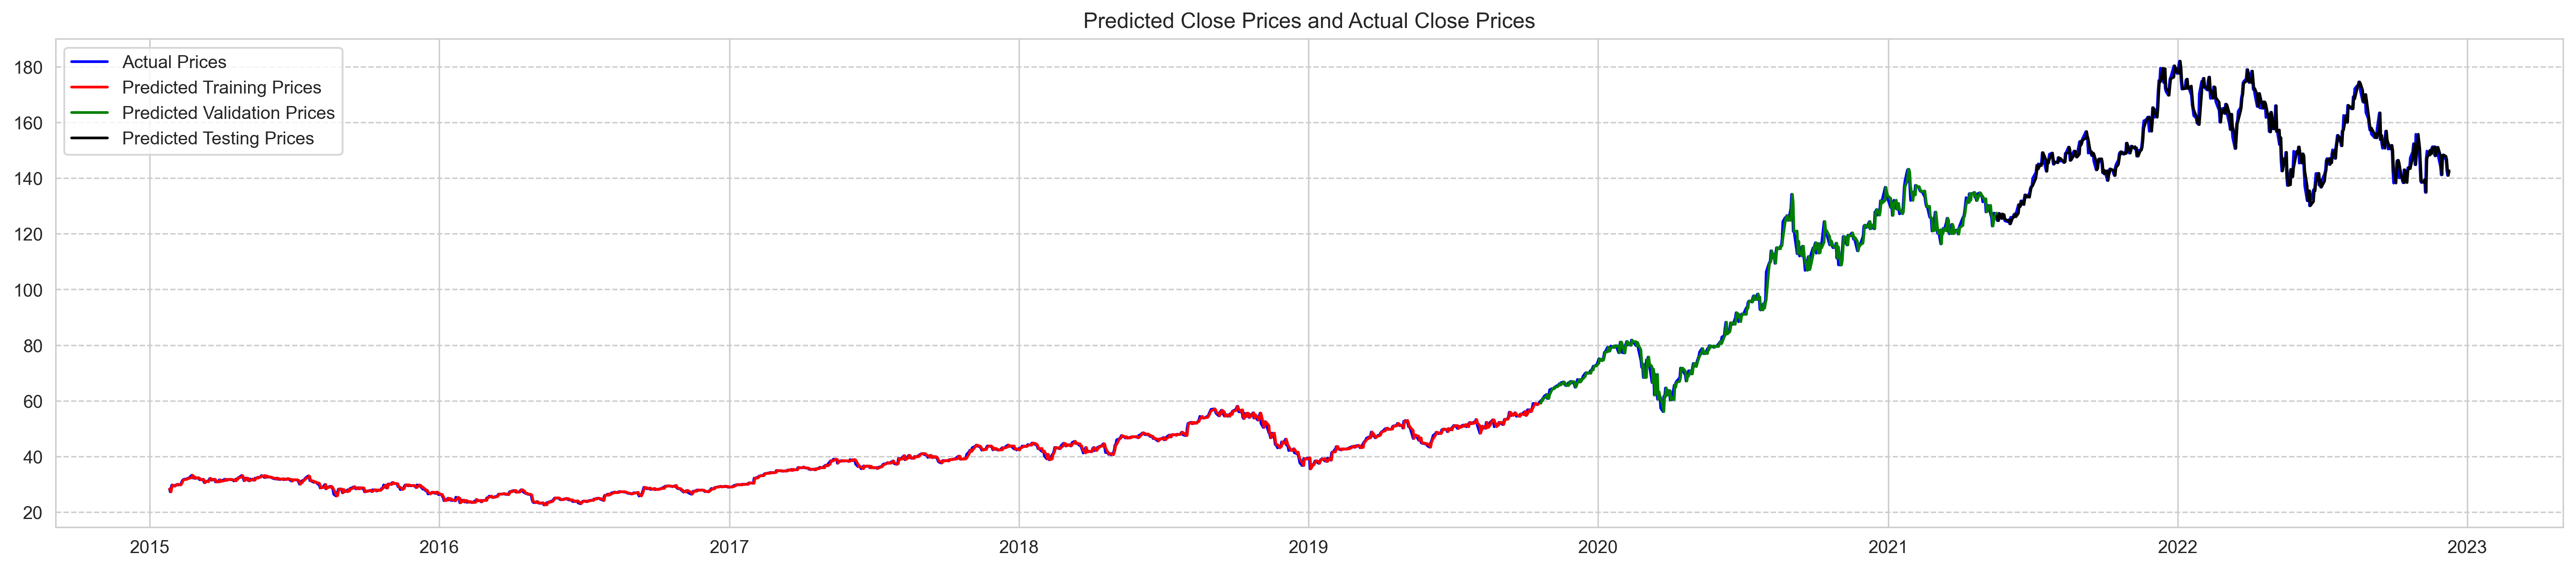

1186 396 396
1186 396 396
396
(1186,)
[28.275  27.285  28.8275 ... 58.5925 58.82   59.1025]
[28.260118 28.290117 27.300117 ... 58.84512  58.607616 58.835117]
{'mape': 0.011101163, 'me': 0.010900657, 'mae': 0.42041433, 'mpe': 0.00031824855, 'rmse': 0.6196725287386738, 'corr': 0.9979351394038897, 'minmax': 0.010981380939483643}
(396,)
[ 60.1275    59.990005  60.795     60.895004  61.645     62.262505
  60.8225    60.815     62.19      63.955     64.375     64.2825
  64.31      64.8575    65.035     65.55      65.49      66.11751
  65.66      66.44      66.77501   66.57251   65.7975    65.5025
  65.445     66.5925    66.07251   66.96001   66.8125    66.04
  64.8625    65.435     66.395004  67.677505  66.73      67.12001
  67.692505  67.865     68.7875    69.965     70.1025    69.935
  70.005     69.86      71.        71.0675    72.4775    72.45
  72.88      73.412506  75.08751   74.3575    74.95      74.5975
  75.7975    77.4075    77.582504  79.240005  78.17      77.835
  78.81      79.6

In [425]:
lookback = 15 # choose sequence length
pred_length = 15
normalised_AAPL_df,scaler = data_normalisation(AAPL_df.copy())
x_train, y_train,x_val,y_val, x_test, y_test = split_train_test_data(normalised_AAPL_df, lookback, pred_length)# change the num_feature value for using more features
# x_test = np.squeeze(x_test)
print(x_train[0])

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)

dataset_train = MyDataLoader(x_train, y_train)
dataset_test = MyDataLoader(x_test, y_test)
dataset_val = MyDataLoader(x_val, y_val)

batch_size = 32
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)

input_seq = len(x_train[0])
input_dim = len(x_train[0][0])
print(input_dim)
hidden_dim = 128
emsize = input_dim  # embedding dimension 192
d_hid =  64 # dimension of the feedforward network model in nn.TransformerEncoder 192
nlayers = 3  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder 8
nhead = 5  # number of heads in nn.MultiheadAttention 12
dropout = 0.1  # dropout probability 0.1
num_layers = 1
output_dim = pred_length
print(input_dim)
# model = AttentionalLSTM(input_dim, output_dim, hidden_dim, num_layers, output_dim)
model = TransformerModel(emsize,input_seq, nhead, d_hid, nlayers, output_dim, dropout)
# model = TransAm()
if train_on_gpu:
    model.cuda()
MAE_Loss = nn.L1Loss()
# criterion = torch.nn.MSELoss()
NLL_Loss = nn.GaussianNLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
alpha = 100
gamma = 0.0001

model = train(model, train_loader, val_loader, optimizer, MAE_Loss, NLL_Loss, alpha, gamma)
#     model.load_state_dict(torch.load('1_googd_model_without.pt'))

evaluate(model, x_train, y_train, x_val, y_val, x_test, y_test, AAPL_df, lookback, pred_length)

In [372]:
len(x_train[0][0])

38

In [338]:
AAPL_df['Close'][-16:]

1991    142.649994
1992    142.160004
1993    144.490005
1994    145.470001
1995    143.210007
1996    136.500000
1997    134.509995
1998    132.369995
1999    132.300003
2000    135.449997
2001    132.229996
2002    131.860001
2003    130.029999
2004    126.040001
2005    129.610001
2006    129.929993
Name: Close, dtype: float64

In [343]:
model.eval()
test_index = -1
test_input = torch.unsqueeze(x_test[test_index],0)
test_output = model(test_input.cuda()).detach().cpu().numpy()
test_output = denormalise(AAPL_df, test_output)
test_output

array([[142.65   , 142.7435 , 142.65   , 142.65   , 142.87189, 142.65   ,
        142.91603, 143.00774, 143.07147, 143.13806, 143.17126, 143.22588,
        143.24411, 143.31763, 143.38046]], dtype=float32)